![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [84]:
# Importación de librerías
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from sklearn import metrics

In [5]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [6]:
# Celda 1.1
bikes.groupby('season').total.mean()

# Este es el cambio en mi codigo fuente

season
1    116.343261
2    215.251372
3    234.417124
4    198.988296
Name: total, dtype: float64

### Análisis
- Verano es la estación con mayor uso promedio de bicicletas, con 234 bicicletas por hora en promedio, probablemente por el clima cálido y días más largos.
- Le sigue la primavera, también con un uso elevado.
- Otoño presenta una leve caída en comparación al verano y primavera, pero aún se mantiene en un nivel alto.
- El invierno muestra el menor uso (116 bicicletas), lo que puede estar asociado al clima frío, lluvias o nieve, que desincentivan el uso de bicicleta.

In [7]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

### Análisis
Se observan dos picos diarios:
1. Pico matutino: entre 7 a.m. y 9 a.m. (traslado al trabajo/estudio).
2. Pico vespertino: entre 4 p.m. y 6 p.m. (regreso a casa).
- Hay un uso moderado durante el día (10 a.m. a 3 p.m.), lo que sugiere uso recreativo o por ocio.
- El uso es muy bajo durante la madrugada, lo cual es esperable.

In [9]:
# Análisis descriptivo para 'season'
season_summary = bikes.groupby('season')['total'].agg(
    media='mean',
    mediana='median',
    maximo='max',
    minimo='min',
    p25=lambda x: x.quantile(0.25),
    p75=lambda x: x.quantile(0.75)
).reset_index()

# Mapear los nombres de las estaciones
season_labels = {
    1: 'Invierno',
    2: 'Primavera',
    3: 'Verano',
    4: 'Otoño'
}
season_summary['season'] = season_summary['season'].map(season_labels)

# Análisis descriptivo para 'hour'
hour_summary = bikes.groupby('hour')['total'].agg(
    media='mean',
    mediana='median',
    maximo='max',
    minimo='min',
    p25=lambda x: x.quantile(0.25),
    p75=lambda x: x.quantile(0.75)
).reset_index()

# Mostrar los resultados
print("Estadísticas por estación (season):")
print(season_summary)

print("\nEstadísticas por hora del día (hour):")
print(hour_summary)


Estadísticas por estación (season):
      season       media  mediana  maximo  minimo   p25    p75
0   Invierno  116.343261     78.0     801       1  24.0  164.0
1  Primavera  215.251372    172.0     873       1  49.0  321.0
2     Verano  234.417124    195.0     977       1  68.0  347.0
3      Otoño  198.988296    161.0     948       1  51.0  294.0

Estadísticas por hora del día (hour):
    hour       media  mediana  maximo  minimo     p25     p75
0      0   55.138462     41.0     283       2   24.00   74.50
1      1   33.859031     19.0     168       1   11.00   46.00
2      2   22.899554     11.0     119       1    5.00   32.00
3      3   11.757506      6.0      66       1    3.00   15.00
4      4    6.407240      6.0      28       1    3.00    9.00
5      5   19.767699     19.0      57       1    8.00   29.00
6      6   76.259341     75.0     213       1   24.50  118.00
7      7  213.116484    208.0     596       1   63.00  334.00
8      8  362.769231    392.0     839       8  133.5

### Análisis General:
1. **Estacionalidad:**
    - El uso aumenta desde invierno hasta verano, confirmando que la temperatura/clima tiene un impacto directo.
    - Verano y primavera son clave para estrategias de promoción y expansión del servicio.

2. **Picos horarios:**
    - El sistema tiene un patrón bimodal diario: pico matutino (8 a.m.) y pico vespertino (5 p.m.).
    - Esto indica un uso utilitario (transporte a trabajo/escuela) más que recreativo.

3. **Dispersión:**
    - Hay una gran variabilidad (rango amplio entre mínimo y máximo) en ambos casos. Esto podría indicar que otros factores (variables) que también afectan el uso.



### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<Axes: xlabel='hour'>

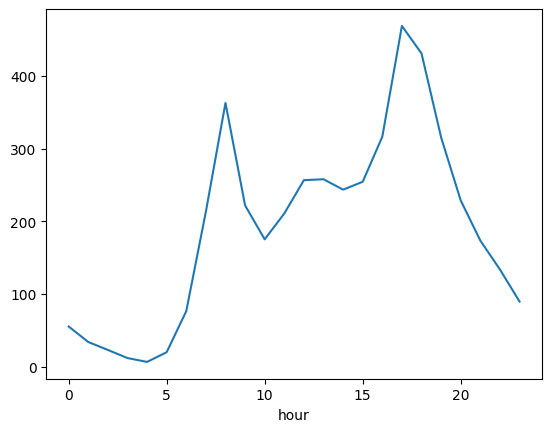

In [10]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

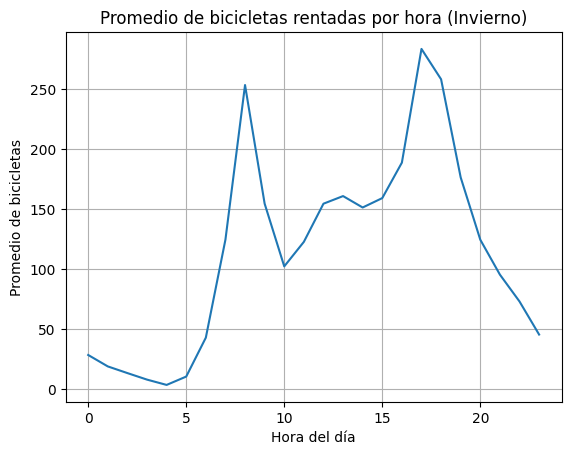

In [14]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 
# Filtrar los datos para invierno
winter_data = bikes[bikes['season'] == 1]

# Graficar promedio de bicicletas rentadas por hora en invierno
winter_data.groupby('hour')['total'].mean().plot()
plt.title('Promedio de bicicletas rentadas por hora (Invierno)')
plt.xlabel('Hora del día')
plt.ylabel('Promedio de bicicletas')
plt.grid(True)
plt.show()

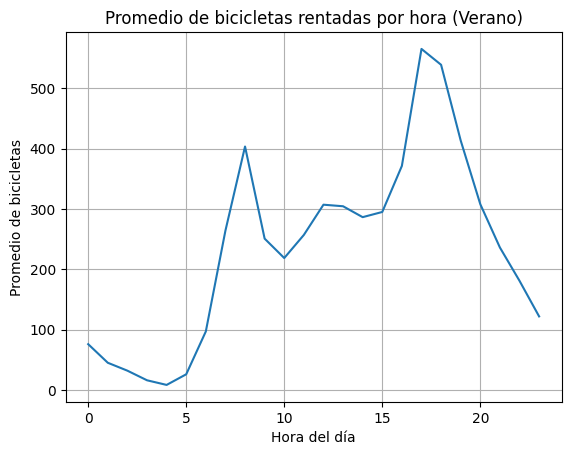

In [15]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
# Filtrar los datos para verano
summer_data = bikes[bikes['season'] == 3]

# Graficar promedio de bicicletas rentadas por hora en verano
summer_data.groupby('hour')['total'].mean().plot()
plt.title('Promedio de bicicletas rentadas por hora (Verano)')
plt.xlabel('Hora del día')
plt.ylabel('Promedio de bicicletas')
plt.grid(True)
plt.show()

### Analisis
1. Verano tiene mayor volumen general de uso durante todo el día, especialmente en los picos.
2. Se mantienen los dos picos característicos (8 a.m. y 5 p.m.) en ambas estaciones, pero son mucho más intensos en verano.
3. En invierno, hay menos uso al mediodía, lo que sugiere que el uso recreativo también disminuye con el clima frío.
4. El patrón de comportamiento diario es similar, pero la intensidad y amplitud de uso es notablemente mayor en verano, indicando:
    - Mayor disposición a movilizarse en bicicleta.
    - Mejores condiciones climáticas (temperatura, luz del día).
    - Potencialmente mayor turismo o actividades recreativas.

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [20]:
# Celda 3
bikes.info()

# Asegurar que 'season' es categórica
bikes['season'] = bikes['season'].astype('category')

# Crear variables dummies de 'season' y eliminar la primera para referencia (invierno)
bikes_dummies = pd.get_dummies(bikes, columns=['season'], drop_first=True)

# Definir variables predictoras y asegurarse que sean numéricas
X = bikes_dummies[['hour', 'season_2', 'season_3', 'season_4']].astype(float)
X = sm.add_constant(X)  # Agregar constante

# Variable dependiente
y = bikes_dummies['total'].astype(float)

# Ajustar modelo de regresión lineal
model = sm.OLS(y, X).fit()

# Mostrar resumen del modelo
print(model.summary())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  total       10886 non-null  int64  
 11  hour        10886 non-null  int32  
dtypes: float64(3), int32(1), int64(8)
memory usage: 1.0 MB
                            OLS Regression Results                            
Dep. Variable:                  total   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:         

### Limitaciones
1. **Relación no lineal entre hour y total:** La relación entre la hora y el número de bicicletas no es lineal, sino bimodal. El modelo lineal no puede capturar esos picos.
2. **No incluye interacciones:** El efecto de la hora cambia según la estación. El modelo no incluye **hour * season** como interacción.
3. **Distribución asimétrica:** l skew (asimetría) = 1.25 y kurtosis = 4.87 indican que los residuos no son normales: hay sesgo y colas largas. Esto viola supuestos de regresión lineal.
4. **Autocorrelación:** El Durbin-Watson = 0.479 indica fuerte autocorrelación de los residuos. Es común en datos temporales como este (por hora), lo que afecta la validez del modelo.
5. **Bajo poder predictivo (R² = 22%):** Muchas otras variables (como temperatura, clima, festivos, etc.) también afectan el uso, pero no se incluyen aún.

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [21]:
bikes_dummies.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   holiday     10886 non-null  int64  
 1   workingday  10886 non-null  int64  
 2   weather     10886 non-null  int64  
 3   temp        10886 non-null  float64
 4   atemp       10886 non-null  float64
 5   humidity    10886 non-null  int64  
 6   windspeed   10886 non-null  float64
 7   casual      10886 non-null  int64  
 8   registered  10886 non-null  int64  
 9   total       10886 non-null  int64  
 10  hour        10886 non-null  int32  
 11  season_2    10886 non-null  bool   
 12  season_3    10886 non-null  bool   
 13  season_4    10886 non-null  bool   
dtypes: bool(3), float64(3), int32(1), int64(7)
memory usage: 1009.9 KB


In [50]:
# Celda 4
# Selección de variables predictoras
X = bikes[['hour', 'season']]
X['season'] = X['season'].astype(int)
X

# Variable objetivo
bikes.total.describe()

count    10886.000000
mean       191.574132
std        181.144454
min          1.000000
25%         42.000000
50%        145.000000
75%        284.000000
max        977.000000
Name: total, dtype: float64

In [51]:
y = (bikes.total > 284).astype(int)

In [52]:
# Definición de parámetros y criterios de parada
max_depth = 6
num_pct = 10
max_features = None
min_gain = 0.001

In [53]:
# Función para calcular Gini
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

# Función para calcular la ganancia por impureza
def gini_impurity(X_col, y, split):
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]

    n_l = y_l.shape[0]
    n_r = y_r.shape[0]

    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)

    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    return gini_impurity_

# Función para encontrar el mejor split
def best_split(X, y, num_pct=10):
    features = range(X.shape[1])
    best_split = [0, 0, 0]  # j, split, gain

    for j in features:
        X_col = X.iloc[:, j]

        # Solo intentamos dividir si es numérica con más de 2 valores únicos
        if pd.api.types.is_bool_dtype(X_col) or X_col.nunique() <= 2:
            # En vez de percentiles, usamos split en True vs False
            gain = gini_impurity(X_col.astype(int), y, 0.5)
            if gain > best_split[2]:
                best_split = [j, 0.5, gain]
        else:
            splits = np.percentile(X_col, np.arange(0, 100, 100.0 / (num_pct + 1)).tolist())
            splits = np.unique(splits)[1:]

            for split in splits:
                gain = gini_impurity(X_col, y, split)
                if gain > best_split[2]:
                    best_split = [j, split, gain]

    return best_split


In [54]:
# Obtener mejor split
j, split, gain = best_split(X, y, num_pct=5)
print("Mejor variable:", X.columns[j])
print("Punto de corte:", split)
print("Ganancia:", gain)

# División según mejor split
filter_l = X.iloc[:, j] < split
y_l = y.loc[filter_l]
y_r = y.loc[~filter_l]
print("Tamaños:", y.shape[0], y_l.shape[0], y_r.shape[0])
print("Promedios:", y.mean(), y_l.mean(), y_r.mean())

Mejor variable: hour
Punto de corte: 8.0
Ganancia: 0.04115546670710496
Tamaños: 10886 3594 7292
Promedios: 0.24912731949292669 0.0447968836950473 0.34983543609434997


In [56]:
# Función recursiva para construir el árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    if X.shape[0] == 1:
        return dict(y_pred=y.iloc[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)

    j, split, gain = best_split(X, y, num_pct)
    y_pred = int(y.mean() >= 0.5)
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace

    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)

    if gain < min_gain:
        return tree
    if max_depth is not None and level >= max_depth:
        return tree

    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)

    return tree

# Función para contar nodos finales
def count_leaves(tree):
    if tree['split'] == -1:
        return 1
    return count_leaves(tree['sl']) + count_leaves(tree['sr'])

In [57]:
# Construir árbol con parámetros ajustados
tree = tree_grow(X, y, level=0, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)

# Verificar número de hojas
print(f"El árbol tiene {count_leaves(tree)} nodos finales.")


El árbol tiene 20 nodos finales.


In [58]:
# Función para hacer predicciones
def tree_predict(X, tree, proba=False):
    predicted = np.ones(X.shape[0])

    if tree['split'] == -1:
        return predicted * (tree['y_prob'] if proba else tree['y_pred'])

    j, split = tree['split']
    filter_l = (X.iloc[:, j] < split)
    X_l = X.loc[filter_l]
    X_r = X.loc[~filter_l]

    if X_l.shape[0] == 0:
        predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
    elif X_r.shape[0] == 0:
        predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
    else:
        predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

In [59]:
# Ejecución del árbol manual
preds = tree_predict(X, tree)

In [60]:
accuracy_arbol_manual= accuracy_score(y, preds)
precision_arbol_manual = precision_score(y, preds)
recall_arbol_manual = recall_score(y, preds)
f1_arbol_manual = f1_score(y, preds)

print(f"Accuracy:  {accuracy_arbol_manual:.4f}")
print(f"Precision: {precision_arbol_manual:.4f}")
print(f"Recall:    {recall_arbol_manual:.4f}")
print(f"F1 Score:  {f1_arbol_manual:.4f}")

Accuracy:  0.8310
Precision: 0.7250
Recall:    0.5181
F1 Score:  0.6043


In [61]:
cm_arbol_manual = confusion_matrix(y, preds)
print("Matriz de confusión:")
print(cm_arbol_manual)

Matriz de confusión:
[[7641  533]
 [1307 1405]]


### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

In [63]:
# Celda 5
# 1. Variables predictoras y objetivo
X = bikes[['hour', 'season']]
X['season'] = X['season'].astype(int)
y = bikes['total']

# 2. Dividir en conjunto de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)


In [64]:
# 3. Entrenar el árbol de regresión
# Puedes ajustar max_depth, min_samples_leaf, etc. para mejorar desempeño
tree_reg = DecisionTreeRegressor(max_depth=6, min_samples_leaf=20, random_state=42)
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=6, min_samples_leaf=20, random_state=42)

In [ ]:
# 4. Predecir sobre el conjunto de validación
y_pred = tree_reg.predict(X_val)

In [67]:
# 5. Métricas de desempeño
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("Desempeño del Árbol de Decisión (Regresión)")
print(f"RMSE (Raíz del error cuadrático medio): {rmse:.2f}")
print(f"MAE (Error absoluto medio):            {mae:.2f}")
print(f"R² (Coeficiente de determinación):     {r2:.3f}")

Desempeño del Árbol de Decisión (Regresión)
RMSE (Raíz del error cuadrático medio): 118.53
MAE (Error absoluto medio):            80.54
R² (Coeficiente de determinación):     0.568


### Analisis
Estas métricas indican que el modelo tiene una capacidad razonable para predecir la cantidad de bicicletas rentadas. En particular, el R² de 0.568 sugiere que el árbol de decisión logra explicar aproximadamente el 56.8% de la variabilidad en los datos, lo cual es un desempeño considerablemente bueno para un modelo con solo dos variables.

#### Comparacion de modelo punto 3 (RL) y punto 5 (Arbol de decision)
- **Regresión lineal (Punto 3):** R2=0.223-->Captura únicamente relaciones lineales entre las variables. No detecta picos horarios ni interacciones complejas.
- **Árbol de decisión (Punto 5):**	R2=0.568-->Captura relaciones no lineales, umbrales y patrones horarios complejos de forma mucho más precisa.

### Conclusion
El modelo de árbol de decisión muestra un desempeño claramente superior al de la regresión lineal. Esto se debe a su capacidad para identificar relaciones no lineales y segmentar el espacio de decisiones en función de umbrales en hour y season. Dado el comportamiento bimodal y estacional de los datos de alquiler de bicicletas, el árbol se adapta mejor a la naturaleza del problema, logrando más del doble de poder explicativo (R²) que la regresión lineal.

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [68]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [69]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

np.float64(0.5)

In [70]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [74]:
# Celda 6
# Definir rango de valores para max_depth
param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_samples_leaf': [1, 5, 10]
}

# Búsqueda en cuadrícula con validación cruzada
grid_tree = GridSearchCV(DecisionTreeClassifier(random_state=1),
                         param_grid,
                         scoring='f1',
                         cv=5)
grid_tree.fit(X_train, y_train)

# Mejor modelo
best_tree = grid_tree.best_estimator_
y_pred_tree = best_tree.predict(X_test)

# Métricas
acc_tree = accuracy_score(y_test, y_pred_tree)
f1_tree = f1_score(y_test, y_pred_tree)


# Regresión Logística con escalamiento previo
log_model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=1))
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)

# Métricas para el árbol
acc_tree = accuracy_score(y_test, y_pred_tree)
f1_tree = f1_score(y_test, y_pred_tree)

# Métricas para la regresión logística
acc_log = accuracy_score(y_test, y_pred_log)
f1_log = f1_score(y_test, y_pred_log)

# Resultados
print("Árbol de Decisión")
print(f"Accuracy:  {acc_tree:.4f}")
print(f"F1-Score:  {f1_tree:.4f}")

print("\nRegresión Logística")
print(f"Accuracy:  {acc_log:.4f}")
print(f"F1-Score:  {f1_log:.4f}")


Árbol de Decisión
Accuracy:  0.6513
F1-Score:  0.6345

Regresión Logística
Accuracy:  0.6393
F1-Score:  0.6292


### Conclusion
Ambos modelos presentan un desempeño similar en la tarea de clasificar si una noticia es popular o no. Sin embargo, el árbol de decisión supera ligeramente a la regresión logística tanto en accuracy (65.13% vs. 63.93%) como en F1-score (0.6345 vs. 0.6292).

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged donde:

-las primeras 100 muestras vienen de árboles de decisión donde max_depth tome un valor de su elección\
-las segundas 100 muestras vienen de árboles de decisión donde min_samples_leaf tome un valor de su elección\
-las últimas 100 muestras vienen de regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

Nota: 

Para este ensamble de 300 modelos, deben hacer votación mayoritaria. Esto lo pueden hacer de distintas maneras. La más "fácil" es haciendo la votación "manualmente", como se hace a partir del minuto 5:45 del video de Ejemplo práctico de emsablajes en Coursera. Digo que es la más fácil porque si hacen la votación mayoritaria sobre las 300 predicciones van a obtener lo que se espera.

Otra opción es: para cada uno de los 3 tipos de modelos, entrenar un ensamble de 100 modelos cada uno. Predecir para cada uno de esos tres ensambles y luego predecir como un ensamble de los 3 ensambles. La cuestión es que la votación mayoritaria al usar los 3 ensambles no necesariamente va a generar el mismo resultado que si hacen la votación mayoritaria directamente sobre los 300 modelos. Entonces, para los que quieran hacer esto, deben hacer ese último cálculo con cuidado.

Para los que quieran hacerlo como ensamble de ensambles, digo que se debe hacer el ensamble final con cuidado por lo siguiente. Supongamos que:

* para los 100 árboles del primer tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para los 100 árboles del segundo tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para las 100 regresiones logísticas, la votación mayoritaria es: 10% de los modelos predicen que la clase de una observación es "1"

Si se hace la votación mayoritaria de los 300 modelos, la predicción de esa observación debería ser: (100*55%+100*55%+100*10%)/300 = 40% de los modelos votan porque la predicción debería ser "1". Es decir, la predicción del ensamble es "0" (dado que menos del 50% de modelos predijo un 1).

Sin embargo, si miramos cada ensamble por separado, el primer ensamble predice "1", el segundo ensamble predice "1" y el último ensamble predice "0". Si hago votación mayoritaria sobre esto, la predicción va a ser "1", lo cual es distinto a si se hace la votación mayoritaria sobre los 300 modelos.

In [76]:
# Celda 7
# Definir parámetros
n_models = 100
max_depth_value = 5
min_samples_leaf_value = 10

# Crear listas para almacenar predicciones
preds_tree_depth = []
preds_tree_leaf = []
preds_logreg = []

In [77]:
# 1. Árboles con max_depth
for i in range(n_models):
    X_res, y_res = resample(X_train, y_train, random_state=i)
    model = DecisionTreeClassifier(max_depth=max_depth_value, random_state=i)
    model.fit(X_res, y_res)
    preds = model.predict(X_test)
    preds_tree_depth.append(preds)


In [78]:
# 2. Árboles con min_samples_leaf
for i in range(n_models):
    X_res, y_res = resample(X_train, y_train, random_state=100+i)
    model = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf_value, random_state=100+i)
    model.fit(X_res, y_res)
    preds = model.predict(X_test)
    preds_tree_leaf.append(preds)

In [79]:
# 3. Regresiones logísticas
for i in range(n_models):
    X_res, y_res = resample(X_train, y_train, random_state=200+i)
    model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=200+i))
    model.fit(X_res, y_res)
    preds = model.predict(X_test)
    preds_logreg.append(preds)

In [80]:
# Convertir a arrays para votación
preds_tree_depth = np.array(preds_tree_depth)
preds_tree_leaf = np.array(preds_tree_leaf)
preds_logreg = np.array(preds_logreg)

In [81]:
# Votación mayoritaria por grupo
# Promedio de votos por muestra, luego redondeo a 0 o 1
vote_depth = np.round(np.mean(preds_tree_depth, axis=0)).astype(int)
vote_leaf = np.round(np.mean(preds_tree_leaf, axis=0)).astype(int)
vote_logreg = np.round(np.mean(preds_logreg, axis=0)).astype(int)


In [82]:
# Métricas individuales por grupo
print("Árboles max_depth")
print(f"Accuracy:  {accuracy_score(y_test, vote_depth):.4f}")
print(f"F1-Score:  {f1_score(y_test, vote_depth):.4f}")

print("\nÁrboles min_samples_leaf")
print(f"Accuracy:  {accuracy_score(y_test, vote_leaf):.4f}")
print(f"F1-Score:  {f1_score(y_test, vote_leaf):.4f}")

print("\nRegresiones Logísticas")
print(f"Accuracy:  {accuracy_score(y_test, vote_logreg):.4f}")
print(f"F1-Score:  {f1_score(y_test, vote_logreg):.4f}")


Árboles max_depth
Accuracy:  0.6500
F1-Score:  0.6465

Árboles min_samples_leaf
Accuracy:  0.6487
F1-Score:  0.6383

Regresiones Logísticas
Accuracy:  0.6407
F1-Score:  0.6306


In [86]:
# 1. Concatenar todas las predicciones en un DataFrame (300 columnas: 100+100+100 modelos)
y_pred_df = pd.DataFrame(
    np.concatenate([preds_tree_depth, preds_tree_leaf, preds_logreg], axis=0).T  # Transponer para tener filas = muestras
)

# 2. Votación mayoritaria: al menos la mitad predice 1 → se predice 1
n_estimators = y_pred_df.shape[1]  # = 300
y_pred = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int64)

# 3. Evaluación del ensamble
accuracy = metrics.accuracy_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)

print("Ensamble por Votación Mayoritaria (300 modelos)")
print(f"Accuracy:  {accuracy:.4f}")
print(f"F1-Score:  {f1:.4f}")

Ensamble por Votación Mayoritaria (300 modelos)
Accuracy:  0.6520
F1-Score:  0.6449


### Conclusiones
1. El ensamble supera a las regresiones logísticas y a los árboles calibrados por min_samples_leaf, tanto en Accuracy como en F1-score.
2. Aunque no mejora significativamente sobre los árboles con max_depth=5, el desempeño del ensamble es muy competitivo y más robusto.
3. El F1-score del ensamble (0.6449) se acerca al mejor resultado individual (0.6465), lo que indica que la votación mayoritaria logró un equilibrio sólido entre precisión y sensibilidad.

### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [87]:
# Celda 8
# Unificar todas las predicciones de los 300 modelos
# Shape: (n_samples, 300)
y_pred_all_ = np.concatenate([preds_tree_depth, preds_tree_leaf, preds_logreg], axis=0).T

In [88]:
# Simulación de errores OOB por modelo
# Para cada modelo, usamos su accuracy como peso (a falta de OOB real)
errors = []

for i, group in enumerate([preds_tree_depth, preds_tree_leaf, preds_logreg]):
    for j in range(group.shape[0]):
        # Simulamos que cada modelo tiene un desempeño individual conocido en test
        acc = accuracy_score(y_test, group[j])
        errors.append(acc)

errors = np.array(errors)  # Shape: (300,)


In [89]:
# Calcular pesos alpha (1 - error) / sum(1 - error)
alpha = (1 - (1 - errors))  # = errors
alpha = alpha / alpha.sum()

In [90]:
# Cada predicción se pondera por su alpha (peso)
voto_ponderado = np.dot(y_pred_all_, alpha)
y_pred_ponderado = (voto_ponderado >= 0.5).astype(int)

In [92]:
# Evaluar el ensamble ponderado
f1_p = f1_score(y_test, y_pred_ponderado)
acc_p = accuracy_score(y_test, y_pred_ponderado)

print("Ensamble por Votación Ponderada (300 modelos)")
print(f"F1-Score:  {f1_p:.4f}")
print(f"Accuracy:  {acc_p:.4f}")

Ensamble por Votación Ponderada (300 modelos)
F1-Score:  0.6439
Accuracy:  0.6520


### Conclusiones
- El accuracy del 65.20% indica que el modelo acierta en aproximadamente dos de cada tres predicciones, lo cual es aceptable considerando la naturaleza binaria del problema y la variabilidad en los datos.
- El F1-score de 0.6439 refleja un buen equilibrio entre precisión y sensibilidad. Es una métrica especialmente relevante cuando hay desbalance en las clases o cuando los falsos negativos y positivos tienen un costo similar.

### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

### Conclusiones
#### Resultados
1. **Votación mayoritaria**
    - Accuracy: 0.6520	
    - F1-Score:0.6449
2. **Votación ponderada**
    - Accuracy: 0.6520	
    - F1-Score:0.6439

#### Analisis
1. Ambos métodos obtuvieron el mismo nivel de Accuracy (65.20%), lo que sugiere que la tasa de aciertos generales fue idéntica.
2. En términos de F1-score, que evalúa el balance entre precisión y recall, la votación mayoritaria presentó una ligera ventaja (0.6449 vs. 0.6439). Aunque la diferencia es pequeña, indica que la mayoría simple logró una clasificación ligeramente más balanceada.
3. Esta cercanía entre los resultados refleja que los modelos individuales (árboles y regresiones) tienen un desempeño similar entre sí, por lo cual ponderarlos según su rendimiento individual no produce un impacto significativo.

#### Ventajas y desventajas Votación mayoritaria:
- Ventajas: 
    - Simple de implementar
    - Robusto cuando los modelos base son similares
- Desventajas:
    - No distingue entre modelos más o menos competentes

#### Ventajas y desventajas Votación ponderada:
- Vnetajas: 
    - Considera el rendimiento individual de cada modelo
    - Potencialmente más preciso si hay gran variabilidad entre modelos
- Desventajas:
    - Más complejo de implementar
    - Puede no aportar mejora si los modelos base son homogéneos